# Exercises - Week 8 - Gradient Descent
#### Simon Lee, BIO-322, Machine Learning for Bioengineers, Winter 2022

Assume the noise in a linear regression setting comes from a Laplace
distribution, i.e. the conditional probability density of the response is given by
$p(Y = y | X = x, \beta) = \frac1{2s}\exp(-\frac{|y - x^T\beta|}{s})$.
For simplicity we assume throughout this exercise that the intercept $\beta_0 = 0$
and does not need to be fitted.
(a) Generate a training set of 100 points with the following data generator.
Notice that the noise follows a Laplace distribution instead of a normal distribution.
For once, we do not use a `DataFrame` here but represent the input explicitly as a matrix and the full dataset as a `NamedTuple`. If you run `data = data_generator()`, you can access the input matrix as `data.x` and the output vector as `data.y`.
```julia
function data_generator(; n = 100, β = [1., 2., 3.])
    x = randn(n, 3)
    y = x * β .+ rand(Laplace(0, 0.3), n)
    (x = x, y = y)
end
```

In [1]:
begin
    using Pkg
    Pkg.activate(joinpath(Pkg.devdir(), "MLCourse"))
    using DataFrames, MLJ, MLJLinearModels, MLCourse, Random,
	      Distributions, Plots, LinearAlgebra, Zygote
    import MLCourse: gradient_descent
end

  Activating project at `~/.julia/dev/MLCourse`


In [2]:
function data_generator(; n = 100, β = [1., 2., 3.])
    x = randn(n, 3)
    y = x * β .+ rand(Laplace(0, .3), n)
    (x = x, y = y)
end

data_generator (generic function with 1 method)

In [3]:
data = data_generator()

(x = [1.3045546328948665 2.0473035683996916 -0.03848084705336671; -0.007130127362344831 0.9906047461913341 -1.3097628591321884; … ; 1.4912003286668682 -0.711247761844934 1.0497290346157238; -0.13963606388126484 -0.6267825081423526 1.3081148324068446],
 y = [5.235334125353757, -2.8386286512472223, -1.2391454205618933, 0.943550401714798, 1.0584507224945254, -1.1809534861880118, -0.3173607076018273, -0.9113499405030423, 0.921345217307602, -4.216176330095353  …  -7.490528029307157, -5.532056845170268, -6.689620238674532, -2.328786414984796, 4.533985059767779, 2.611114187467745, 11.295076314796665, -2.4272819303607314, 2.51213571375358, 2.5548508477001226],)

(b) Calculate with paper and pencil the negative log-likelihood loss. Apply transformations to the negative log-likelihood function to obtain a good loss function for gradient descent based on the practical considerations in the slides.
The solution you should find is
$$
\tilde L = \frac1{n} \sum_{i=1}^n |y_i - x_i^T\beta|.
$$

### Solution
The negative log-likelihood loss is given by

$$
\begin{align}
L(\beta) &= -\sum_{i=1}^n \log P(y_i|x_i,\beta)\\
&= -\sum_{i=1}^n \log\left(\frac{1}{2s}\exp\left(-\frac{|y_i - x_i^T\beta|}{s}\right)\right)\\& = \sum_{i=1}^n \log(2s) + \frac{1}{s}\sum_{i=1}^n |y_i - x_i^T\beta|.
\end{align}
$$
The term $\sum_{i=1}^n \log(2s)$ does not depend on the parameters. It will therefore not appear in any partial derivative and not have any influence on gradient descent.


In order not to have to scale the learning rate with ``n`` we take the mean instead of the sum and we drop the 1/s (which is a constant and can be seen as part of the learning rate). Therefore, we optimize the following function:

$$
\tilde L = \frac1{n} \sum_{i=1}^n |y_i - x_i^T\beta|.
$$

(c) Code a function to compute the loss on the training set for a given
parameter vector. *Hint:* use matrix multiplication, e.g. `data.x * β`.

In [4]:
loss(β) = mean(abs.(data.y .- data.x * β))

loss (generic function with 1 method)

(d) Perform gradient descent on the training set. Plot the learning curve to see
whether gradient descent has converged. If you see large fluctuations at the end
of training, decrease the learning rate. If the learning curve is not flat at
the end, increase the maximal number of steps. To see well the loss towards the end of gradient descent it is advisable to use log-scale for the y-axis (`yscale = :log10`).


In [5]:
begin 
	struct Tracker{T} # structure definition with parametric type
		path::T
	end
	Tracker(x::T) where T = Tracker{Vector{T}}([copy(x)]) # constructor
	(t::Tracker)(x) = push!(t.path, copy(x))        # making the object callable
end

In [6]:
begin
    params = randn(3)
    tracker = Tracker(params)
    gradient_descent(loss, params, 1e-3, 10^4,
                     callback = tracker)
end

3-element Vector{Float64}:
 1.0081499134741712
 2.0484215326729696
 2.9799990333485264

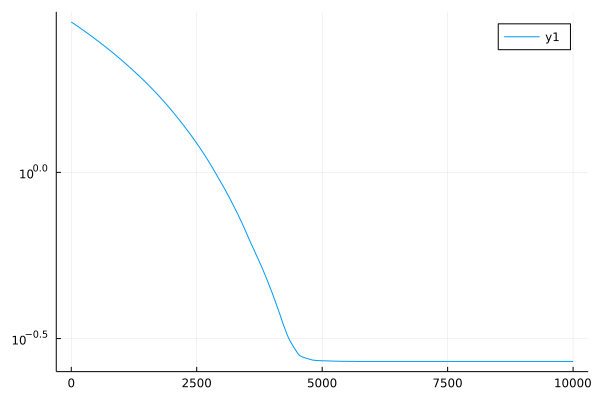

In [7]:
plot(loss.(tracker.path), yscale = :log10)

(e) Estimate the coefficients with the standard linear regression.
Hint: do not forget that we fit without intercept (use `fit_intercept = false` in the `LinearRegressor`).


In [8]:
linreg = machine(LinearRegressor(fit_intercept = false),
	             DataFrame(data.x, :auto),
	             data.y);

In [9]:
fit!(linreg);

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /Users/simonlee/.julia/packages/MLJLinearModels/YvwMg/src/mlj/interface.jl:39


(f) Compare which method (d) or (e) found parameters closer to the one of our data generating process `[1, 2, 3]` and explain your finding.


Let us now compare the fitted values to the parameters of the data generator.

In [10]:
norm(tracker.path[end] - [1, 2, 3])

0.05301985083937234

In [11]:
norm(last.(fitted_params(linreg).coefs) - [1, 2, 3])

0.04857742561449869

We see that gradient descent on the negative log-likelihood finds parameters closer to the true ones compared to linear regression. This is due to the fact that the noise in our data generation process is not Gaussian (there are, however, some rare cases of training sets where linear regression is superior).

In [12]:
data_test = data_generator(n = 10^6);

We used here the distance between the fitted and the true parameters to assess the quality of the fit. We could also evaluate the test error with the `rmse` (root mean squared error) or the `mae` (mean absolute error) and find that the test error is lower for the laplace regressor. Note that the mean absolute error is the canonical error measure if the error is Laplacian, because it is proportional to the negative log-likelihood.

In [13]:
rmse(data_test.x * tracker.path[end], data_test.y)

0.4271479841078223

In [14]:
rmse(predict(linreg, data_test.x), data_test.y)

0.42666634985454693

In [15]:
mae(data_test.x * tracker.path[end], data_test.y)

0.30404224287185216

In [16]:
mae(predict(linreg, data_test.x), data_test.y)

0.3034312052360075